# Market Microstructure Project
### Bid & Ask Optimization

**Ana Luisa Espinoza López**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad
from functools import partial
import math

In [2]:
import bidask as ba #librería con funciones para bid & ask

In [3]:
import utils as u #Archivo .py con funciones de soporte

Implementation of Copeland & Galai's Model for bid and ask prices optimization. In the following project, the objective consists in implement this method in python to solve for the optimal bid & ask prices with the following parameters:

- $P ~ Erlang$($K=60$, $\lambda=3$)
- $\prod_I = 0.4: $Probability of an informed trade
- $\prod_{LB}(S) = 0.5 - 0.08S$ where $\prod_{LB}: [0, 0.5],$ and $S = (A-S_0)$
- $\prod_{LS}(S) = 0.5 - 0.08S$ where $\prod_{LS}: [0, 0.5],$ and $S = (S_0 - B)$
- $S_0 = 19.90$
- $S: [10, 33]$


### Plot with Price distribution

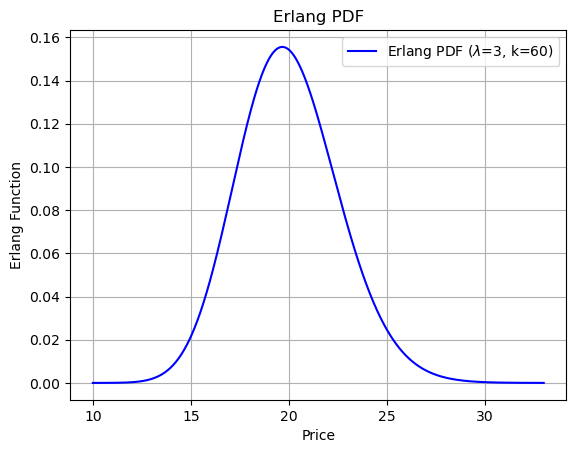

In [4]:
# Definimos el rango de valores para x
x = np.linspace(10, 33, 1000)
lambda_ = 3
k = 60

# Calculamos los valores de la función de densidad de probabilidad de Weibull
y = u.erlang_pdf(x, lambda_, k)

plt.plot(x, y, label=f'Erlang PDF ($\\lambda$={lambda_}, k={k})',color = 'blue')
plt.xlabel('Price')
plt.ylabel('Erlang Function')
plt.title('Erlang PDF')
plt.legend()
plt.grid(True)
plt.show()

### Bid, Ask and Spot price

### Plot with Expected revenue